In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from astroNN.nn.layers import MCDropout
import numpy as np
import matplotlib.pyplot as plt

2022-05-16 02:25:15.729281: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-16 02:25:15.729296: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df=pd.read_csv('data/jla.csv')
z = df.values[:,0]
y = df.values[:,1:]

In [3]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [4]:
# r = scalerz.transform(z.reshape(-1, 1))
# predh = model.predict(r)

In [5]:
ffnn_do = tf.keras.models.load_model('models/09032022_MCDO_V2/FFNN_MCDO3.h5', custom_objects={'MCDropout': MCDropout})

2022-05-16 02:25:16.791555: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-16 02:25:16.791576: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-16 02:25:16.791593: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (isidro-pc): /proc/driver/nvidia/version does not exist
2022-05-16 02:25:16.791768: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
test_batch_size = len(z)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 3))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = ffnn_do.predict(z)
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)

2022-05-16 02:25:16.963101: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


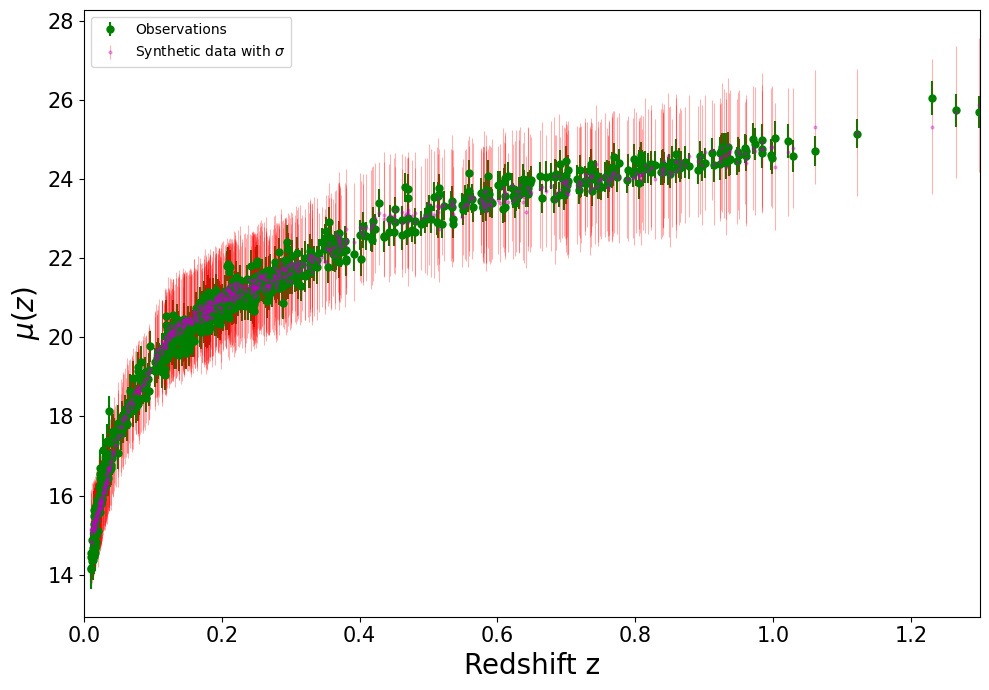

In [7]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
# plt.plot(z, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df['zcmb'], df['mb'], np.sqrt(df['errors']+df['dmb']**2), fmt='g.', markersize=10, label='Observations')
plt.errorbar(scalerz.inverse_transform(z), prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,2)
plt.xlim(0, 1.3)
# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

In [8]:
# save fake data
mocky_mcdo = np.concatenate((prediction_mc_dropout[:,0].reshape(-1,1), sigma.reshape(-1,1)), axis=1)
mockmuz_ffnn_mcdo = np.concatenate((z.reshape(-1,1), mocky_mcdo), axis=1)
np.savetxt("sn_jla_mcdo_mock.dat",mockmuz_ffnn_mcdo, delimiter=" ")

## Now only at the new redshifts (existing in Pantheon but not in JLA and < z_jlamax)

In [9]:
znews = pd.read_csv('data/jla.csv', usecols=[0])
md_pantheon = pd.read_csv('data/jla.csv', usecols=[1])
err_pantheon = pd.read_csv('data/jla.csv', usecols=[3])

In [10]:
test_batch_size = len(z)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 3))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = ffnn_do.predict(scalerz.transform(znews.values))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)

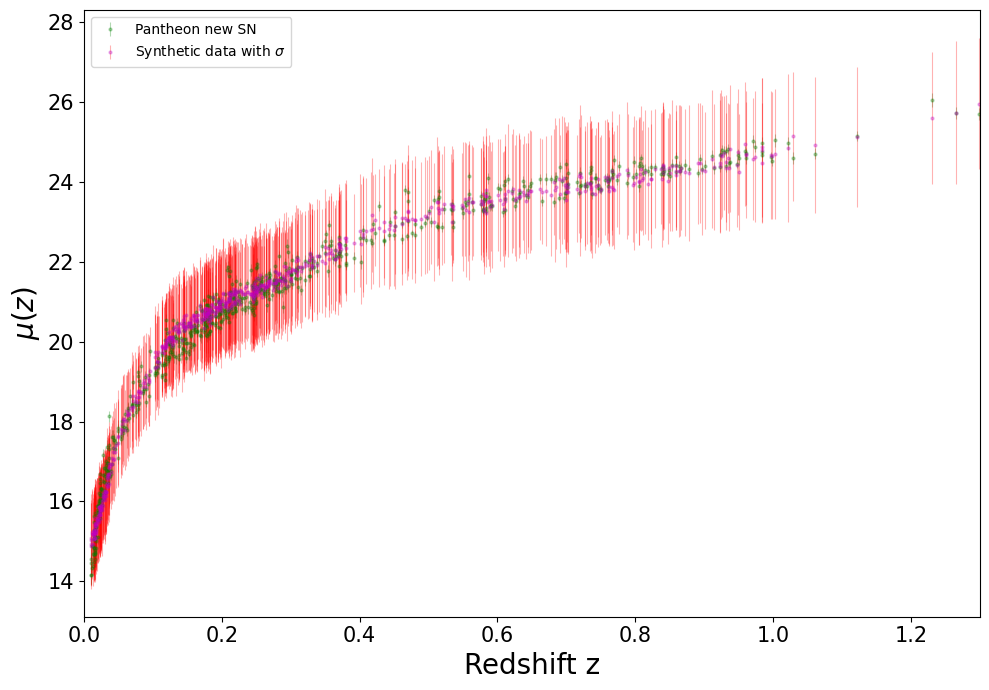

In [11]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


plt.errorbar(znews.values, md_pantheon.values, yerr=err_pantheon.values[:,0], markersize=2, fmt='o', 
             ecolor='g', capthick=2, elinewidth=0.8, alpha=0.3, c='g',
             label='Pantheon new SN')

plt.errorbar(znews.values, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,2)
plt.xlim(0, 1.3)
# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

In [13]:
# save fake data
mocky_mcdo = np.concatenate((prediction_mc_dropout[:,0].reshape(-1,1), sigma.reshape(-1,1)), axis=1)
mockmuz_ffnn_mcdo = np.concatenate((znews.values, prediction_mc_dropout[:,0].reshape(-1,1)), axis=1)
np.savetxt("sn_news.dat",mockmuz_ffnn_mcdo, delimiter=" ")
ncov = len(sigma)
neuralcov = np.diag(prediction_mc_dropout[:,1])

np.savetxt("sn_news_cov.dat", neuralcov , header="#{}x{}".format(ncov, ncov), delimiter=' ' )

## Obtaining diag cov files to JLA and Pantheon 

In [15]:
jlafilecov = '/home/isidro/Documents/github/simplemc_tests/simplemc/data/jla_v0_covmatrix.dat'
pantheoncov = '/home/isidro/Documents/github/simplemc_tests/simplemc/data/pantheon_errors.txt'

jlacov = np.loadtxt(jlafilecov, skiprows=1).reshape(740,740)
diagjla = np.diag(jlacov)
diagjla = np.diag(diagjla)

pantheoncov = np.loadtxt(pantheoncov, skiprows=1).reshape(1048,1048)
diagpantheon = np.diag(pantheoncov)
diagpantheon = np.diag(diagpantheon)

np.shape(jlacov), np.shape(pantheoncov), np.shape(diagjla), np.shape(diagpantheon)

((740, 740), (1048, 1048), (740, 740), (1048, 1048))

In [16]:
np.savetxt("diag_cov_jla.dat", diagjla , header="#740x740", delimiter=' ' )
np.savetxt("diag_cov_pantheon.dat", diagpantheon , header="#1048x1048", delimiter=' ' )

## Not in JLA from Pantheont to simplemc format

In [ ]:
notjla = 'data/not_in _jla.csv'
df1 = pd.read_csv(notjla, usecols=[0, 1])
df1.head()

In [ ]:
noterrors = pd.read_csv(notjla, usecols=[3])
noterrors.head()

In [ ]:
np.savetxt("not_jla.dat", df1.values, header="#z mb", delimiter=' ' )
l = len(noterrors.values)
np.savetxt("not_jla_cov.dat",np.diag(noterrors.values.reshape(l,)), header="#{}x{}".format(l, l), delimiter=' ' )

In [ ]:
np.diag(noterrors.values.reshape(l,))